Building likelihood maps for a set of representative images.

> TODO: use images from dataset and superimpose the bounding boxes on them

In [1]:
import retinoto_py as fovea
args = fovea.Params(do_fovea=True, batch_size=1, subset_factor=50)
args

Params(image_size=224, do_mask=False, do_fovea=True, rs_min=0.0, rs_max=-6.0, padding_mode='zeros', seed=2018, batch_size=1, num_workers=1, in_memory=False, model_name='convnext_base', num_epochs=24, subset_factor=50, lr=1e-06, delta1=0.1, delta2=0.007, weight_decay=0.03, label_smoothing=0.2, shuffle=True, verbose=False)

In [2]:
dataset = 'bbox'
model_filename = args.data_cache /  f'32_fovea_model_name={args.model_name}_dataset={dataset}.pth'
model = fovea.load_model(args, model_filename=model_filename)

In [3]:

VAL_DATA_DIR = args.DATAROOT / f'Imagenet_{dataset}' / 'val'
val_dataset = fovea.get_dataset(args, VAL_DATA_DIR)
# val_loader = fovea.get_loader(args, val_dataset)


In [4]:
from torchvision.transforms import v2 as transforms
npy_filename = args.data_cache / '42_likelihood_maps.npy'

# %rm {npy_filename}

resolution = (100, 100)
resolution = (30, 30)
resolution = (20, 20)
size_ratio = .6

if npy_filename.exists():
    results = fovea.np.load(npy_filename)
else:
    n_dataset = len(val_dataset)
    with fovea.torch.no_grad():
        results = fovea.np.ones((resolution[0], resolution[1], n_dataset))
        for i_batch, (image, true_label) in fovea.tqdm(enumerate(val_dataset), total=n_dataset):
            crop_size = min(image.shape[1], image.shape[2])
            image = transforms.CenterCrop(crop_size)(image)

            pos_H, pos_W, probas = fovea.compute_likelihood_map(args, model, image, size_ratio=size_ratio, resolution=resolution)
            results[:, :, i_batch] = probas[:, true_label].cpu().numpy().reshape(resolution)
        fovea.np.save(npy_filename, results)

  0%|          | 0/1000 [00:00<?, ?it/s]

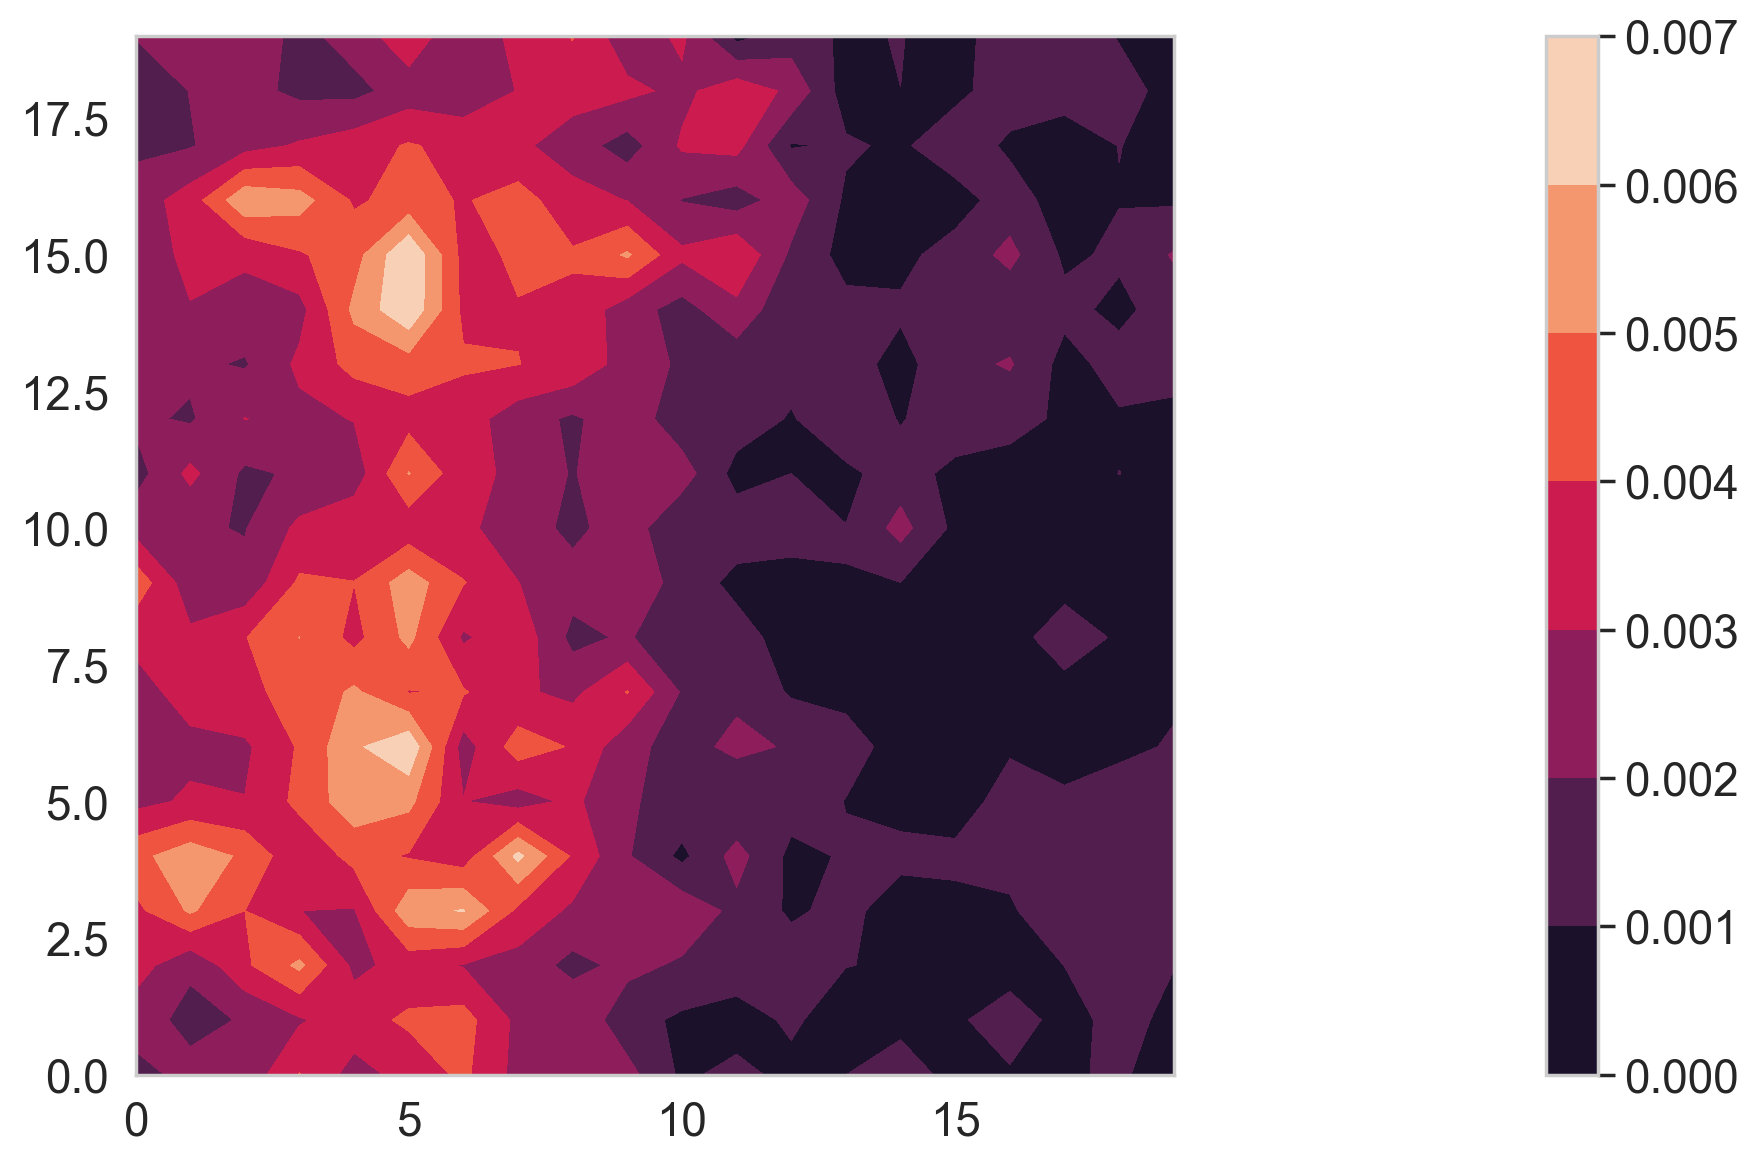

In [5]:
fig, ax = fovea.plt.subplots()
contour = ax.contourf(results.mean(axis=-1))
fig.colorbar(contour, ax=ax)  # Add colorbar
ax.axis('square')
fig.set_facecolor(color='white')
